In [ ]:

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd

In [ ]:
# Step 1: Unzip the dataset
def unzip_dataset(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

zip_path = '/content/archive (3).zip'  # Update with your zip file path
extract_to = '/content/dataset'  # Update with your extraction path
unzip_dataset(zip_path, extract_to)

In [ ]:
data_dir = "/content/dataset/ASD_v4_datasets"

# Update paths to point to the extracted data directories
train_dir = os.path.join( "/content/dataset/ASD_v4_datasets/train")
val_dir = os.path.join("/content/dataset/ASD_v4_datasets/valid")
test_dir = os.path.join("/content/dataset/ASD_v4_datasets/test")

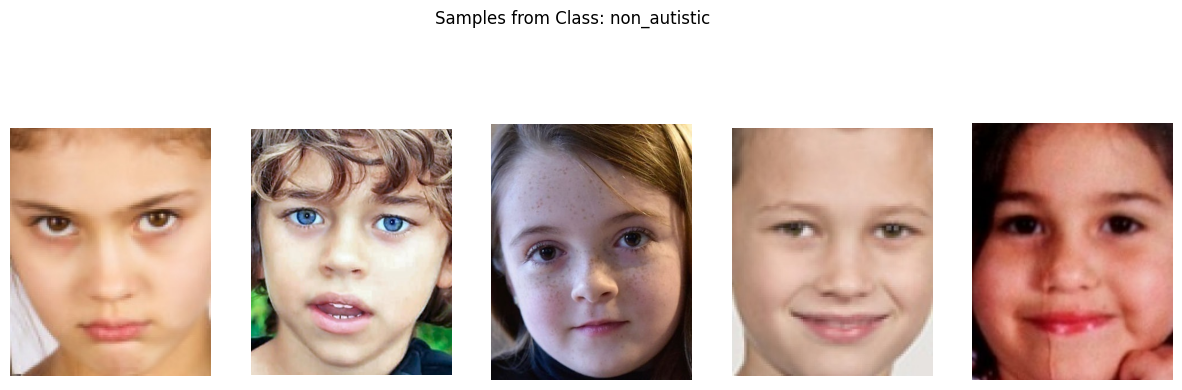

In [ ]:
# 1. Visualize the dataset
def visualize_samples(train_dir, num_samples=5):
    classes = os.listdir(train_dir)
    for cls in classes:
        class_dir = os.path.join(train_dir, cls)
        sample_images = os.listdir(class_dir)[:num_samples]
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Samples from Class: {cls}")
        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

visualize_samples(train_dir)

In [ ]:

# Step 4: Preprocess the dataset
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 2526 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [ ]:


# Step 5: Build the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:

# Step 6: Train the model
epochs = 10
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.6727 - loss: 0.6480 - val_accuracy: 0.8500 - val_loss: 0.3856
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step - accuracy: 0.7616 - loss: 0.4874 - val_accuracy: 0.9000 - val_loss: 0.2571
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.8017 - loss: 0.4207 - val_accuracy: 0.7125 - val_loss: 0.4685
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.7877 - loss: 0.4344 - val_accuracy: 0.9125 - val_loss: 0.2662
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.8407 - loss: 0.3744 - val_accuracy: 0.9250 - val_loss: 0.2580
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.8399 - loss: 0.3497 - val_accuracy: 0.9375 - val_loss: 0.2183
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 392s 4s/step - accuracy: 0.8510 - loss: 0.3422 - val_accuracy: 0.9250 - val_loss: 0.2031
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.8653 - loss: 0.3094 - val_accuracy: 0.9125 - val_loss: 0.

In [ ]:

# Step 7: Evaluate the model

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9378 - loss: 0.1954
Test Accuracy: 91.43%


In [ ]:
# Step 8: Confusion matrix
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype('int32').flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Autism', 'Autism'], yticklabels=['Non-Autism', 'Autism'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step


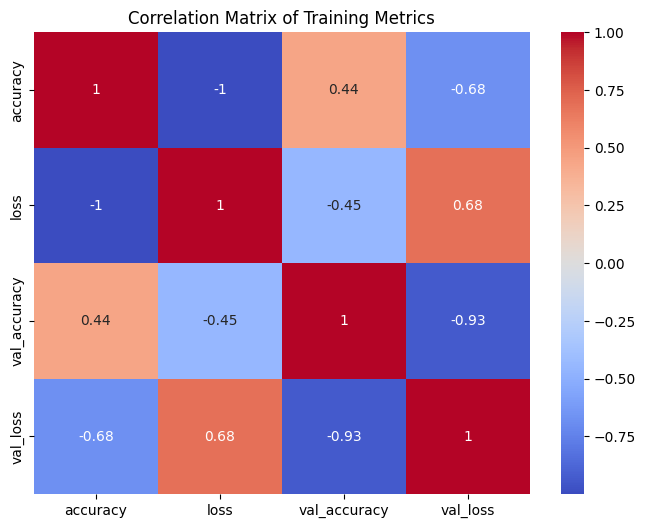

In [ ]:
# Step 9: Correlation matrix
metrics_df = pd.DataFrame(history.history)
plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Training Metrics')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


<ipython-input-28-42bf231ad86c>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction > 0.5)]


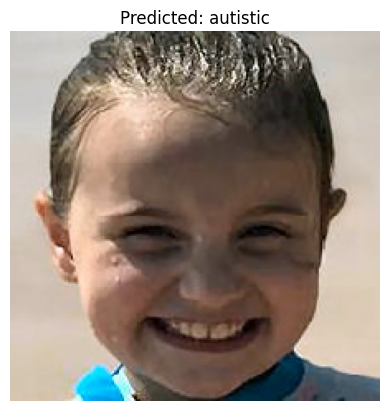

In [ ]:
def predict_single_image(image_path, model, class_labels):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    predicted_class = class_labels[int(prediction > 0.5)]
    return img, predicted_class

# Path to a test image
test_image_path = "/content/dataset/ASD_v4_datasets/test/autistic/ta.025.jpg"  # Replace with actual image path

# Predict and display result
class_labels = list(test_generator.class_indices.keys())
image, result = predict_single_image(test_image_path, model, class_labels)

plt.imshow(image)
plt.title(f"Predicted: {result}")
plt.axis('off')
plt.show()